In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from externals.lore.datamanager import prepare_dataset
from xailib.explainers.lime_explainer import LimeXAITabularExplainer
from xailib.explainers.lore_explainer import LoreTabularExplainer
from xailib.explainers.shap_explainer_tab import ShapXAITabularExplainer
from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

### Load the dataset and prepare it

In [2]:
source_file = 'datasets/german_credit.csv'
class_field = 'default'
# Load and transform dataset 
df = pd.read_csv(source_file, skipinitialspace=True, na_values='?', keep_default_na=True)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = prepare_dataset(df, class_field)
df.head()

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,account_check_status=0 <= ... < 200 DM,account_check_status=< 0 DM,account_check_status=>= 200 DM / salary assignments for at least 1 year,...,housing=rent,job=management/ self-employed/ highly qualified employee/ officer,job=skilled employee / official,job=unemployed/ unskilled - non-resident,job=unskilled - resident,telephone=none,"telephone=yes, registered under the customers name",foreign_worker=no,foreign_worker=yes,default
0,6,1169,4,4,67,2,1,0,1,0,...,0,0,1,0,0,0,1,0,1,0
1,48,5951,2,2,22,1,1,1,0,0,...,0,0,1,0,0,1,0,0,1,1
2,12,2096,2,3,49,1,2,0,0,0,...,0,0,0,0,1,1,0,0,1,0
3,42,7882,2,4,45,1,2,0,1,0,...,0,0,1,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,0,1,0,...,0,0,1,0,0,1,0,0,1,1


### Split the dataset into train and test and scale it

In [3]:
test_size = 0.3
random_state = 42
X_train, X_test, Y_train, Y_test = train_test_split(df[feature_names], df[class_field],
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=df[class_field])

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

### Define and train a logistic regression model

In [4]:
bb = LogisticRegression(C=1, penalty='l2')
bb.fit(X_scaled, Y_train.values)
# pass the model to the wrapper to use it in the XAI lib
bbox = sklearn_classifier_wrapper(bb)

In [5]:
# select a record to explain
inst = X_train.iloc[188].values
print('Instance ',inst[0:10])
print('True class ',Y_train.iloc[18])
print('Predicted class ',bb.predict(inst.reshape(1, -1)))

Instance  [  12 1076    2    2   26    1    1    0    0    0]
True class  1
Predicted class  [1]


### SHAP explainer
##### We first define the explainer method we want to use: SHAP. It produces feature importance. Then, we can define a dictionary containing the SHAP's parameters we want. 
##### Explainer can be: linear, tree, kernel, deep
##### X_train is the training set we want the explainer to train on. It can be all the training set used for the training of the target model, just a piece of it or we can apply a clustering algorithm on it. 

In [6]:
explainer = ShapXAITabularExplainer(bbox)
config = {'explainer' : 'linear', 'X_train' : X_train.iloc[0:100].values, 'feature_pert' : 'interventional'}
explainer.fit(config)

#### We explain the instance and obtain the SHAP values

In [7]:
print('building an explanation')
exp = explainer.explain(inst)
print(exp)

building an explanation
[-3.14654374e+00 -4.89251054e+02 -3.90753475e-01  1.25400902e-02
  8.31464349e-01 -1.12763012e-01 -2.05702546e-02 -5.01662937e-02
 -9.68094062e-02  3.81923244e-05 -2.77116160e-01 -7.53413023e-03
  9.87117610e-02 -3.25979251e-03  7.13981767e-02 -5.79589998e-03
 -1.48785687e-02 -6.80898123e-03 -3.77382829e-02  2.61558728e-02
  1.69495288e-02  0.00000000e+00 -0.00000000e+00  2.51983815e-03
  7.00489125e-04 -0.00000000e+00  1.25570699e-02  1.05360978e-01
 -3.78449695e-03  2.68281002e-04  4.31063042e-02  2.36419604e-03
 -1.75076895e-02  1.59897539e-02  3.47053429e-02 -1.03261568e-02
 -2.34396611e-02 -5.29160464e-03  4.84507066e-02  8.48973368e-02
 -5.42664267e-03  6.68129232e-03  3.97209036e-03  1.77257213e-02
  1.96958605e-02 -1.09858864e-01 -5.38853150e-02 -2.50863187e-02
 -3.24013287e-02  3.78484815e-04  2.28221066e-02 -3.83726099e-03
 -4.01224748e-02  6.93040105e-03  7.00701088e-03  3.67539150e-04
 -5.76512093e-03 -3.66043839e-02 -3.66043839e-02 -1.57078274e-01
 

##### We can use the method plot_shap_values to get a visual representation. 
##### Parameters: feature_names, the list of features, exp, the explanation we want to plot, start and end, which denotes the range of features we want to plot

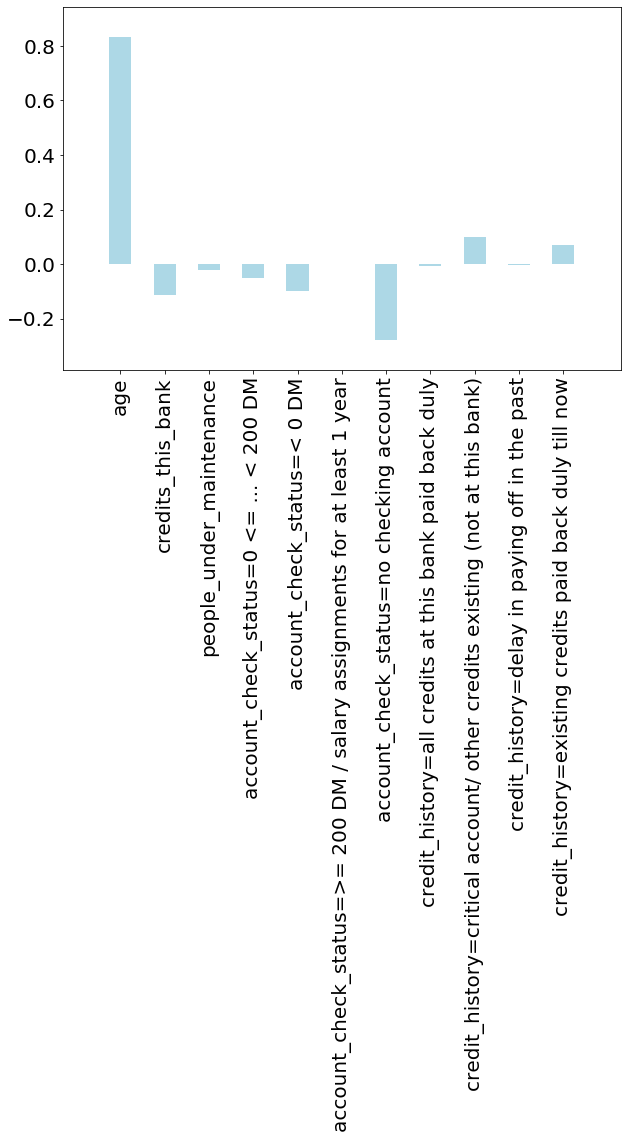

In [8]:
explainer.plot_shap_values(feature_names, exp, 4, 15)

##### We can use the method plot_shap_values_alt  (or plot_shap_values_alt2) to get an interactive visual representation. 
##### Parameters: 
- feature_names: the list of features;
- exp: the explanation we want to plot
- fontDimension: font size (which affects entire plot size)

In [9]:
explainer.plot_shap_values_alt(feature_names, exp)

alt.VConcatChart(...)

### LORE explainer
##### We first define the explainer method we want to use: LORE. It produces rules and counterfactual rules. We can define a dictionary containing the LORE's parameters we want. 
##### neigh_type can be: random, genetic, rndgen, geneticp, rndgenp

In [ ]:
explainer = LoreTabularExplainer(bbox)
config = {'neigh_type':'geneticp', 'size':1000, 'ocr':0.1, 'ngen':10}
explainer.fit(df, class_field, config)
exp = explainer.explain(inst)
print(exp)

### LIME explainer
##### We first define the explainer method we want to use: LIME. It produces feature importances. We can define a dictionary containing the LIME's parameters we want. 
##### There are several parameters we can define: feature selection, discretize continuous, discretizer, sample_around_instance, kernel width, kernel.

In [ ]:
limeExplainer = LimeXAITabularExplainer(bbox)
config = {'feature_selection': 'lasso_path'}
limeExplainer.fit(df, class_field, config)
lime_exp = limeExplainer.explain(inst)
print(lime_exp.as_list())

##### To plot the explanation, we pass the explanation as a list (tuples, where the first element is the feature name and the second the actual feature importance), start and end of the range of features we want to visualize.

In [ ]:
limeExplainer.plot_lime_values(lime_exp.as_list(), 4, 15)

### Define and train a RFClassifier

In [ ]:
bb = RandomForestClassifier(n_estimators=20, random_state=random_state)
bb.fit(X_train.values, Y_train.values)
bbox = sklearn_classifier_wrapper(bb)   

In [ ]:
explainer = ShapXAITabularExplainer(bbox)
config = {'explainer' : 'tree', 'X_train' : X_train.iloc[0:100].values}
explainer.fit(config)

In [ ]:
inst = X_train.iloc[147].values
print('Instance ',inst[0:10])
print('True class ',Y_train.iloc[8])
print('Predicted class ',bb.predict(inst.reshape(1, -1)))

In [ ]:
print('building an explanation')
exp = explainer.explain(inst)
print(exp)

##### We can use the method plot_shap_values to get a visual representation. 
##### Parameters: feature_names, the list of features, exp, the explanation we want to plot, start and end, which denotes the range of features we want to plot. When using Tree explainer, for each record we obtain n feature importance arrays (where n is the number of classes). For the plot, we have to select only one array (in this case we selected the one of the true class).

In [ ]:
explainer.plot_shap_values(feature_names, exp[0], 0, 15)

### LORE explainer

In [ ]:
explainer = LoreTabularExplainer(bbox)
config = {'neigh_type':'rndgen', 'size':1000, 'ocr':0.1, 'ngen':10}
explainer.fit(df, class_field, config)
exp = explainer.explain(inst)
print(exp)

### LIME explainer

In [ ]:
limeExplainer = LimeXAITabularExplainer(bbox)
config = {'feature_selection': 'lasso_path'}
limeExplainer.fit(df, class_field, config)
lime_exp = limeExplainer.explain(inst)
print(lime_exp.as_list())

In [ ]:
limeExplainer.plot_lime_values(lime_exp.as_list(), 5, 10)